# PCA on random matrices

af, started 22.10.26  
revised 23.01.03, 23.03.14, 23.04.21

## Import librairies

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pydiodon as dio
import cppdiodon as cppdio

loading pydiodon - version 23.05.04


## General approach

### Select the dimension of the random matrix and a method

matrix $A$ has $m$ rows and $n$ columns. Specifying the ratio  $\alpha$ between the number of columns and of rows will be useful later when computing eigenvalues of random Gaussian matrices.

In [2]:
m = 10000
alpha = 0.1 # the number of columns is round(n*alpha), see below
k = 500 # prescribed rank for rSVD
n = int(np.round(alpha*m))
#
print("matrix A has", m, "rows and", n, "columns")


matrix A has 10000 rows and 1000 columns


####  Opérations exécutées ou non

In [3]:
full_svd = False            # svd with numpy/Lapack 
rsvd = True                 # svd with Gaussian ranbdom projection
compare_sv = True           # compare sv with full svd and grp
compute_MarPas = True       # computes theoretical eigenvalues of Wishart matrix (Marcenko-Pastur)
plot_observed_ev = True    # plots observed eigenvalues of the Wishart matrix of A (takes time)

### Select the model for building a random matrix

Models are:
- `uniform` for a uniform law in $[-1,1]$
- `gauss` for a normal law $\mathcal{N}(0,1)$  of mean 0 and variance 1

In [4]:
meth = "gauss"

### Building the random matrix

In [5]:
if meth=="uniform":
    A = -1 + 2*np.random.random((m,n))
if meth=="gauss":
    A = np.random.randn(m,n)
#A = np.asanyarray(A, dtype='float32') 
A = np.asanyarray(A, dtype=np.single)     

### Running the PCA of the random matrix

#### py and method is svd

In [6]:
if full_svd==True:
    t_start   = timeit.default_timer()
    Ys, Ls, Vs = dio.pca(A, meth="svd")
    t_stop    = timeit.default_timer()
    print("\nDuration with SVD is", t_stop-t_start)
else:
    print("full SVD not run")

full SVD not run


####  method is rSVD, with pydiodon, not cppdiodon

In [7]:
if rsvd==True:
    t_start   = timeit.default_timer()
    Yg, Lg, Vg = dio.pca(A, k = k, meth="grp")
    t_stop    = timeit.default_timer()
    print("\nDuration with rSVD in pydiodon is", t_stop-t_start)


-----------------------------------------
running pca(), version 21.05.05
Matrix A has 10000 rows and 1000 columns
rank is 500 (full rank if k = -1)
pretreatment is standard
method is grp
------------------------------------------

Computing Omega
Computing A*Omega
running QR
computing B
running SVD of B
computing U

Duration with rSVD in pydiodon is 17.06332794900004


### Comparison of eigenvalues between SVD and rSVD

In [8]:
if full_svd and rsvd: 
    plt.plot(Ls, c="green")
    plt.plot(Lg, c="blue")
    plt.xlabel("rank")
    plt.ylabel("Singular value")
    plt.show()
else:
    print("full svd has not been run!")

full svd has not been run!


- Eigenvalues computed with SVD are in green
- Eigenvalues computed with rSVD are in blue

### Plotting the components

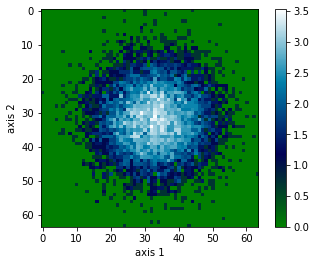

In [9]:
if full_svd:
    dio.plot_components_heatmap(Ys, bins=64)
if rsvd:
    dio.plot_components_heatmap(Yg, bins=64)

## Marcenko-Pastur distribution

The theoretical distribution of the eigenvalues of the empirical variance-covariance matrix $C = \frac{1}{n}\,A'A$ when $A$ is Gaussian with $\sigma=1$ is modeled by Marcenko-Pastur distribution. $C$ is a Wishart matrix. 

Here are the parameters of the distribution which depend on $\alpha$. All eigenvalue are real ($C$ is symmetric) with $a \leq \lambda \leq b$.

In [10]:
a = (1 - np.sqrt(alpha))**2
b = (1 + np.sqrt(alpha))**2
print("a = ", a) 
print("b = ", b) 

a =  0.46754446796632404
b =  1.732455532033676


Here the distribution is computed by computing $y(x)$ such that $P(\lambda \in [x, x+dx]) = y(x) \, dx$. From previous result, $x \in [a,b]$, or $y(x)=0$ if $x < a$ or $x>b$.

In [11]:
x = np.linspace(start=a, stop=b, num=100).tolist()
if alpha==1:
    x	= x[1:]
y = (1/(2*np.pi*alpha))*(np.sqrt((b-x)*(x-a)))/x

Here is the plot $y=y(x)$

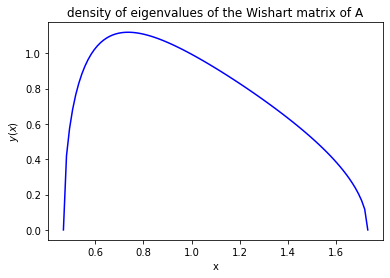

In [12]:
plt.plot(x,y,c="blue")
plt.xlabel("x")
plt.ylabel("$y(x)$")
plt.title("density of eigenvalues of the Wishart matrix of A")
plt.show()

Then, the empirical distribution is displayed as an histogram

In [14]:
if plot_observed_ev:
    C		= (A.T @ A)/n
    L, U 	= np.linalg.eig(C)
    plt.hist(L,bins=30)
    plt.title("Observed distribution")
    plt.show()

#### !!! warning !!! 
il reste un petit hiatus sur le range de l'axe des x ... en cours d'investigation ...

## That's all folks!